In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
%matplotlib inline
from autograd import numpy as np
import numpy.testing
np.testing = numpy.testing
import scipy.spatial
import bayesian_pdes as bpdes
import six
import sympy as sp
import matplotlib.pyplot as plt
import autograd

# Forward Problem

In [3]:
x, y, t, t_bar = sp.symbols('x, y, t, t_bar')
l, alpha = sp.symbols('l, alpha')
k = sp.exp(-(x - y)**2 / (2*l**2)) * sp.exp(-(t-t_bar)**2 / (2*l**2))

def T(k):
    return k.diff(t) - alpha * k.diff(x,x)
def T_bar(k):
    return k.diff(t_bar) - alpha * k.diff(y, y)
def B(k):
    return k
B_bar = B

ops = [T, B]
ops_bar = [T_bar, B_bar]

In [4]:
op_system = bpdes.operator_compilation.compile_sympy(ops, ops_bar, k, [[x, t], [y, t_bar], [l, alpha]], mode='cython')

In [5]:
L = 1.

In [6]:
def g(x):
    return np.zeros((x.shape[0], 1))
def b(x):
    return np.ones((x.shape[0], 1))

In [7]:
def u_0(x):
    return np.zeros_like(x)

In [8]:
times = np.linspace(0,1,11)
x_pts = np.linspace(0,L,11)[:,None]
interior = x_pts[1:-1]
bdy = x_pts[[0, -1]]

fun_args = np.array([0.1, 1.0])

test = np.linspace(0,L,51)[:,None]
init_points = np.column_stack([x_pts, times[0]*np.ones_like(x_pts)])
init_obs = u_0(x_pts)
ics = [(init_points, init_obs)]

In [9]:
def obs_function(t):
    interior_t = np.column_stack([interior, t*np.ones_like(interior)])
    bdy_t = np.column_stack([bdy, t*np.ones_like(bdy)])
    
    return [(interior_t, g(interior_t)), (bdy_t, b(bdy_t))]

def test_function(t):
    test_t = np.column_stack([test, t*np.ones_like(test)])
    return test_t

In [10]:
means, covs = bpdes.parabolic.solve_parabolic(op_system, times, obs_function, test_function, ics, fun_args)

INFO:root:Applying <function T at 0x10ab3d6e0>, <function T_bar at 0x10ab3d398> to points ((11, 2)) and test points ((51, 2))
INFO:bayesian_pdes.parabolic:t=0.1
INFO:root:Applying (), () to points ((11, 2)) and test points ((51, 2))
DEBUG:bayesian_pdes.parabolic:ops has len 1; obs_1 has len 1; ops_bar has len 2; obs_2 has len 2
DEBUG:bayesian_pdes.parabolic:Concatenating K_ttm1; shapes are [[(11, 11)]]
DEBUG:bayesian_pdes.parabolic:About to call schur; shapes are: last_inv: (11, 11) K_ttm1: (11, 11), K_t: (11, 11); K_t_inv: (11, 11)
INFO:root:Applying <function T at 0x10ab3d6e0>, <function T_bar at 0x10ab3d398> to points ((9, 2)) and test points ((51, 2))
INFO:root:Applying <function B at 0x10ab3d578>, <function B at 0x10ab3d578> to points ((2, 2)) and test points ((51, 2))
INFO:bayesian_pdes.parabolic:t=0.2
INFO:root:Applying (), () to points ((11, 2)) and test points ((51, 2))
DEBUG:bayesian_pdes.parabolic:ops has len 1; obs_1 has len 1; ops_bar has len 2; obs_2 has len 2
INFO:root:A

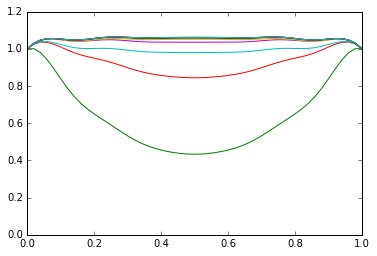

In [11]:
plt.plot(test, np.column_stack(means));